# **Predicting Concrete Compressive Strength**

### Motivation:
Concrete is a fundamental material in civil engineering. Its compressive strength is important for ensuring the safety and durability of structures. However, determining this strength accurately is challenging because it depends on a nonlinear function between several factors, including the age of the concrete and the proportions of its components—such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.
This project aims to apply machine learning techniques to improve the prediction of concrete strength, in order to contribute to better design, quality control, and resource optimization in construction.

### Dataset Explanation:
The dataset is sourced from the UCI Machine Learning Repository and contains 1030 observations with 8 quantitative input variables, and 1 quantitative output variable.
The input variables are: cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, fine aggregate and age. Except for age, the other variables are ingredient quantities in the concrete mixture and measured in *kg in a $m^{3}$* mixture. The age is measured in *days*.
The target, concrete compressive strengt, is measured in *MPa*.

The dataset is available under: https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength

### Data Analytics: Preprocessing
Since there is no missing attribute values according to the information provided by UCI Machine Learning Repository. Data can be directly read from Concrete_data.csv. 

In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from sklearn.model_selection import KFold, cross_validate

%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [3]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ',',
                         decimal = ',',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()
concrete_df.head()

Original data types：
Cement (component 1)(kg in a m^3 mixture)                object
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    object
Fly Ash (component 3)(kg in a m^3 mixture)               object
Water  (component 4)(kg in a m^3 mixture)                object
Superplasticizer (component 5)(kg in a m^3 mixture)      object
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     object
Fine Aggregate (component 7)(kg in a m^3 mixture)        object
Age (day)                                                 int64
Concrete compressive strength(MPa, megapascals)          object
dtype: object

Transfromed datatypes：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a 

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [5]:
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
label_column = 'Concrete compressive strength(MPa, megapascals)'
feature_columns = [c for c in concrete_df.columns if c != label_column]
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      ", and the response variable is:", label_column)

Features are: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)'] , and the response variable is: Concrete compressive strength(MPa, megapascals)


#### Explanation of relevant variables:

The following table shows the meaning and expected effect of respective variables on the concrete compressive strength. 
| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `cement`             | Binder                               | increases strength          |
| `blast_furnace_slag` | Supplementary binder                 | increases strength or neutral                  |
| `fly_ash`            | Supplementary binder                 | increase strength or neutral                  |
| `water`              | Affects workability and hydration    | decreases strength (excess) |
| `superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `coarse_aggregate`   | Filler                               | neutral or mild effect         |
| `fine_aggregate`     | Filler                               | neutral or mild effect         |
| `age`                | Curing time                          | increases strength          |


#### Feature scaling

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]],
      shape=(1030, 8))

#### Distribution of target variable

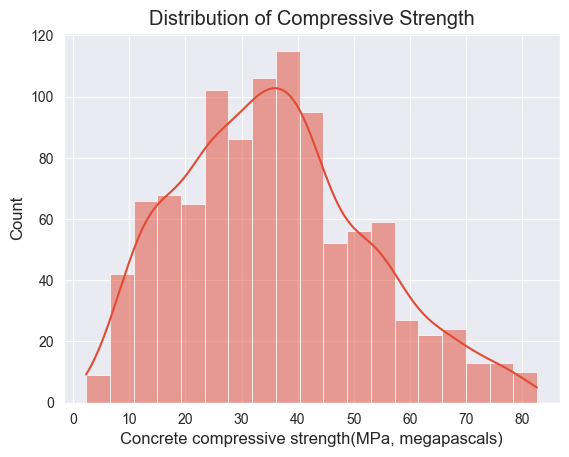

In [7]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

The sns.histplot clearly illustrates that the compressive strength data is not uniformly or normally distributed. Instead, it shows a sporadic and spread-out distribution with many unique or rarely occurring strength values, and potentially some concentrations at the extreme ends of the
measured range.
The data distribution is sparse, has a lack of strong central Tendency, so we need to avoid assumption-heavy models (Simple linear regression) and consider robust models (Decision-tree is expected to perform the best).
That doesn’t mean that we don’t try simple linear regression, but maybe this can already explain why linear regression doesn’t perform well.

#### Correlation between relevant variables:

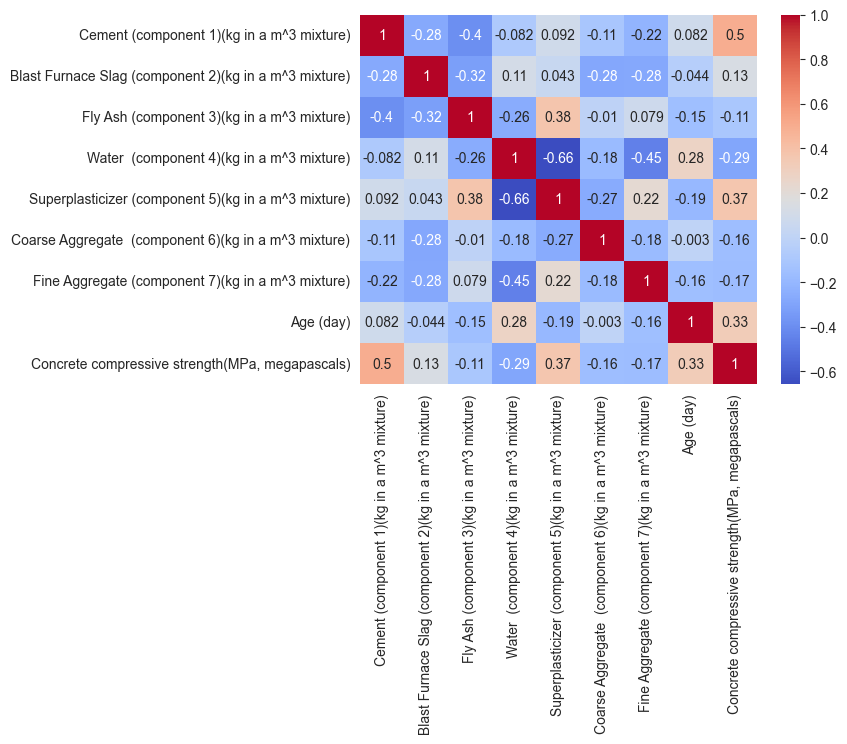

In [8]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### Variables that influence concrete strength:

According to the result of the heatmap, it can be seen that **cement** has a moderately strong positive correlation with concrete strength with a value of +0.50, which indicates more cement usually leads to stronger concrete. **Superplasticizer** also has a positive effect with a value of +0.37.
**Age** has a positive effect too , because concrete gets stronger over time.
**Water** has a negative correlation with strength of -0.29, which means more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasizes that increased water relative to cement typically reduces concrete strength.

The other components like fly Ash, Coarse Aggregate and Fine Aggregate are weakly negatively correlated with concrete strength.

#### Multicollinearity:

The highest multicollinearity is the correlation between **water and superplasticizer**, which has a value of -0.66. This indicates they carry overlapping and opposite information. There is also moderate correlation among **cement**, **blast furnace slag**, and **fly ash** because these may act as partial substitutes in the concrete mix, so they tend to move in opposite directions. 

In [9]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] 
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
Cement (component 1)(kg in a m^3 mixture) 15.457
Blast Furnace Slag (component 2)(kg in a m^3 mixture) 3.329
Fly Ash (component 3)(kg in a m^3 mixture) 4.148
Water  (component 4)(kg in a m^3 mixture) 82.158
Superplasticizer (component 5)(kg in a m^3 mixture) 5.471
Coarse Aggregate  (component 6)(kg in a m^3 mixture) 84.956
Fine Aggregate (component 7)(kg in a m^3 mixture) 72.791
Age (day)            1.699


The variance inflation factors are larger for cement, blast furnace slag, fly ash, water, coarse aggregate, fine aggregate. This also indicates multi-collinearity of the factors mention above.

As mentioned in the lecture content of Machine Learning and Data Analytics(MLDA), VIF equal to 1 shows the absence of collinearity Usually, there is collinearity when VIF is larger than 5.

### Machine Learning Methods:
This project aims to predict concrete compressive strength which is a problem with a quantitative response. According to the lecture content in the fundamental part of MLDA, this task is a **regression task**. In the following part, linear regression, ridge regression, lasso regression, one decision-tree based method are applied. 

### Cross validation:

#### K-fold cross validation:

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [10]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [11]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

#### Linear Regression:

##### Statsmodel, outliers and high leverege points:

In [12]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Concrete compressive strength(MPa, megapascals)   R-squared:                       0.616
Model:                                                         OLS   Adj. R-squared:                  0.613
Method:                                              Least Squares   F-statistic:                     204.3
Date:                                             Sun, 15 Jun 2025   Prob (F-statistic):          6.29e-206
Time:                                                     14:03:29   Log-Likelihood:                -3869.0
No. Observations:                                             1030   AIC:                             7756.
Df Residuals:                                                 1021   BIC:                             7800.
Df Model:                                                        8                                         
Covariance Type:            

According to the result of the fitted model, there is a relationship between the response of concrete compressive strength and **cement, blast furnace slag, fly ash, water, superplasticizer and age**, because they have low p-values, which is smaller than 0.05.

In [13]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Outliers are: [np.int64(381), np.int64(383)]
Comments on joint outliers (in both ax2 and ax3): [np.int64(381), np.int64(383)]


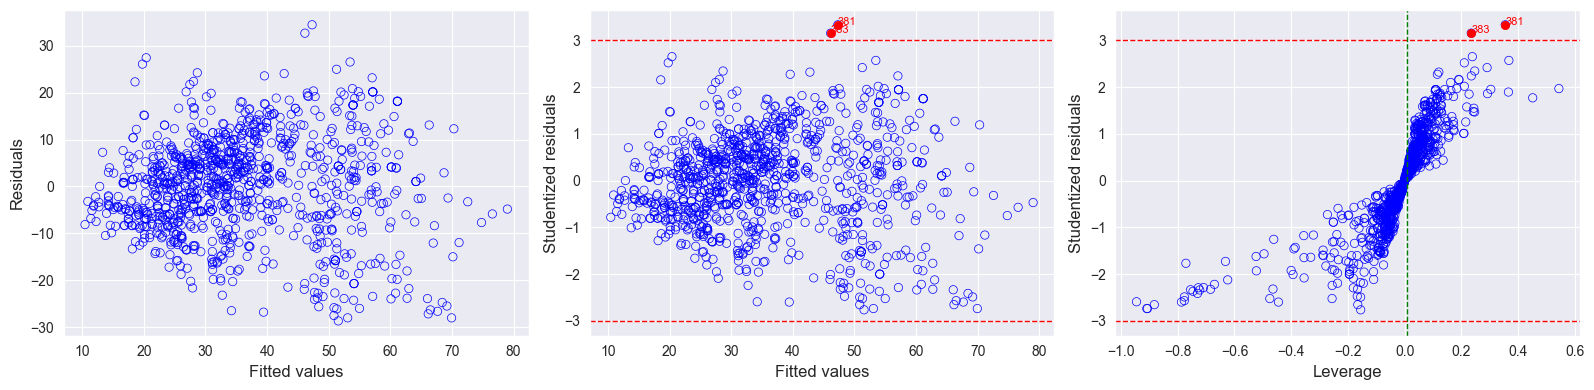

In [14]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

The residuals display a clear pattern, which suggests **non-linearity** in the data. The studentized residuals indicate the presence of two outliers. The leverage plot also reveals several high-leverage points—defined as points with leverage greater than $(p+1)/n=9/1030\approx 0.009$. Notably, both outliers are also high-leverage points. However, since the dataset does not clearly define criteria for excluding data points, all observations, including the outliers, are retained for the subsequent analysis.

##### Scikit-Model:

In [15]:
model = LinearRegression()

mse_scores_lin = cross_val_score(model, X, y, scoring=mse_scorer, cv=kf)

r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", np.mean(mse_scores_lin))    

print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 109.24732740404936

Average R2 across folds: 0.6057530311729299


#### Ridge regression:

In [16]:
scoring = {'mse':'neg_mean_squared_error','R2':'r2'}

# define the model
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = scoring,
        refit = 'mse',
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
model.fit(X, y)
#print(model[2].cv_results_) #to show the results and names

# obtain the results
lambdas = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in model[2].cv_results_['mean_test_mse']]
r2 = [r2 for r2 in model[2].cv_results_['mean_test_R2']]
    
best_model = model.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_r2 = max(r2)

best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2)]

print(f"Best alpha regarding mse:{best_lambda_mse:.2f}, with MSE: {best_mse:.2f}")
print(f"Best alpha regarding r2:{best_lambda_r2:.2f}, with r2: {best_r2:.2f}")
model

Best alpha regarding mse:0.45, with MSE: 59.34
Best alpha regarding r2:0.45, with r2: 0.78


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                              estimator=Ridge(),
                              param_grid={'alpha': array([1.0000e-03, 1.2649e-03, 1.5999e-03, 2.0236e-03, 2.5595e-03,
       3.2375e-03, 4.0949e-03, 5.1795e-03, 6.5513e-03, 8.2864e-03,
       1.0481e-02, 1.3257e-0...
       1.0985e-01, 1.3895e-01, 1.7575e-01, 2.2230e-01, 2.8118e-01,
       3.5565e-01, 4.4984e-01, 5.6899e-01, 7.1969e-01, 9.1030e-01,
       1.1514e+00, 1.4563e+00, 1.8421e+00, 2.3300e+00, 2.9471e+00,
       3.7276e+00, 4.7149e+00, 5.9636e+00, 7.5431e+00, 9.5410e+00,
       1.2068e+01, 1.5264e+01, 1.9307e+01, 2.4421e+01, 3.0888e+01,
       3.9069e+01, 4.9417e+01, 6.2506e+01, 7.9060e+01, 1.0000e+02])},
                              refit='mse',
                              scoring={'R2': 'r2',
                                       'mse': 'neg_mean_squared_error'}))])

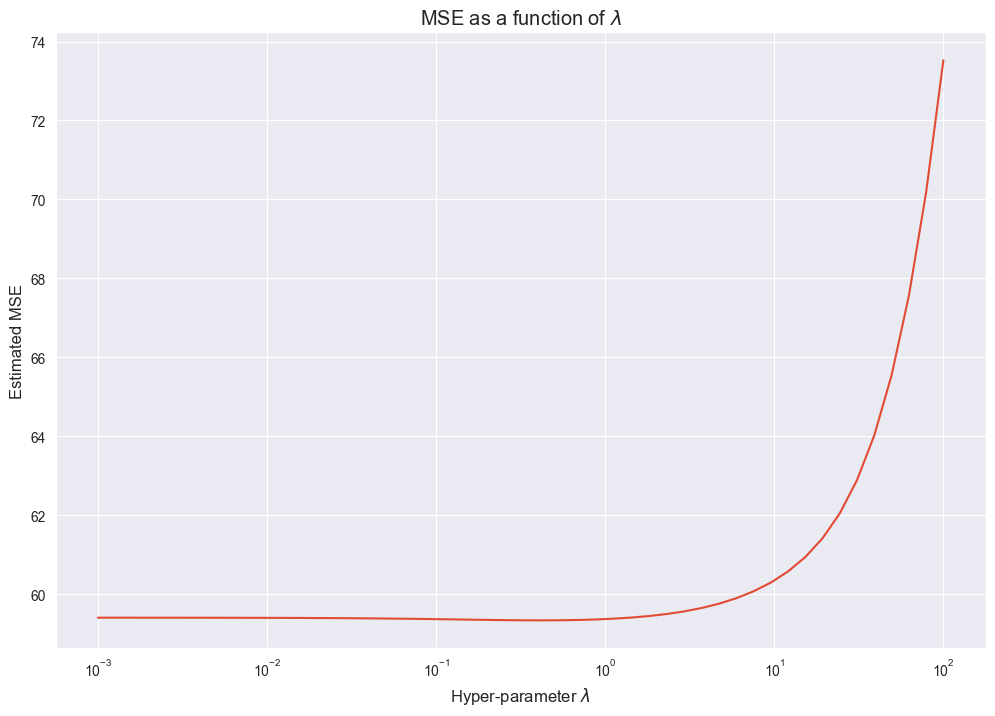

In [17]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

The ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 0.45. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 0.45, where the model achieved the lowest MSE of 59.34. 

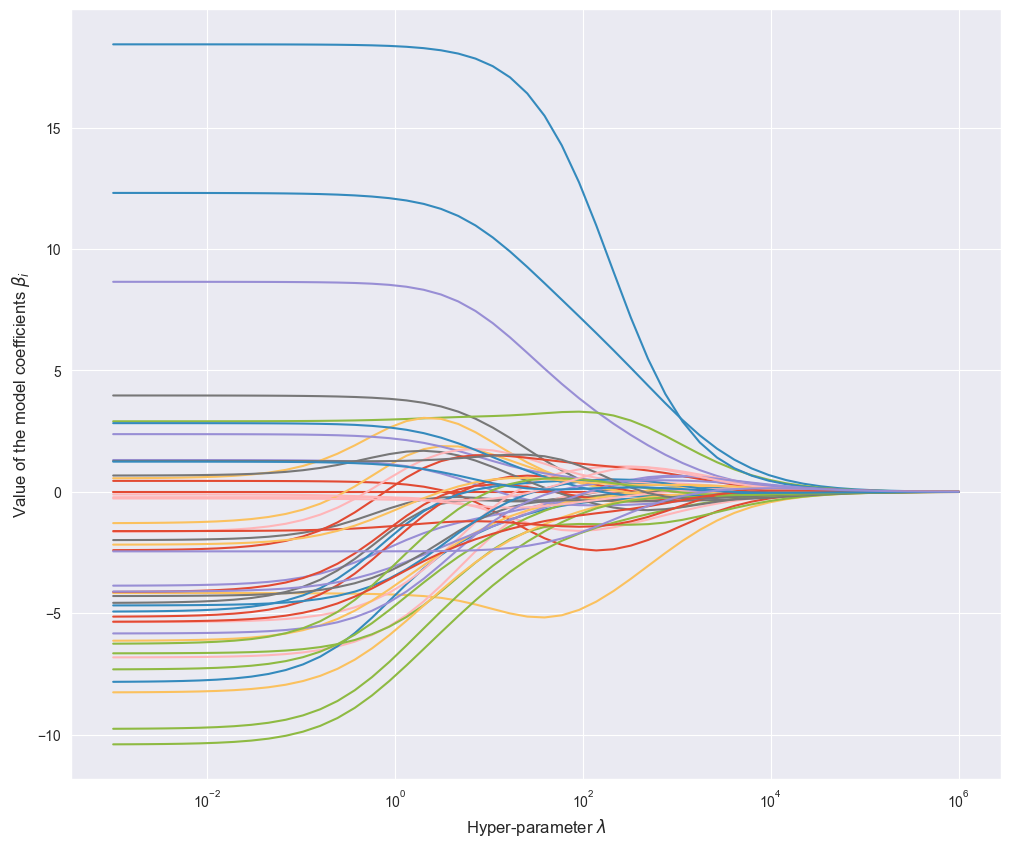

In [18]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Ridge(alpha = lam)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)
    
    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)

ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()

#### Polynomial Regression:

Since there is non-linearity in the data, we use the polynomial regression to train the dataset.

Cement (component 1)(kg in a m^3 mixture):
  Lowest MSE = 210.47 at degree 1
Blast Furnace Slag (component 2)(kg in a m^3 mixture):
  Lowest MSE = 263.37 at degree 5
Fly Ash (component 3)(kg in a m^3 mixture):
  Lowest MSE = 273.15 at degree 4
Water  (component 4)(kg in a m^3 mixture):
  Lowest MSE = 226.06 at degree 5
Superplasticizer (component 5)(kg in a m^3 mixture):
  Lowest MSE = 241.97 at degree 1
Coarse Aggregate  (component 6)(kg in a m^3 mixture):
  Lowest MSE = 267.61 at degree 5
Fine Aggregate (component 7)(kg in a m^3 mixture):
  Lowest MSE = 271.47 at degree 3
Age (day):
  Lowest MSE = 183.45 at degree 4
{'Cement (component 1)(kg in a m^3 mixture)': 1, 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 5, 'Fly Ash (component 3)(kg in a m^3 mixture)': 4, 'Water  (component 4)(kg in a m^3 mixture)': 5, 'Superplasticizer (component 5)(kg in a m^3 mixture)': 1, 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 5, 'Fine Aggregate (component 7)(kg in a m^3 mixture)'

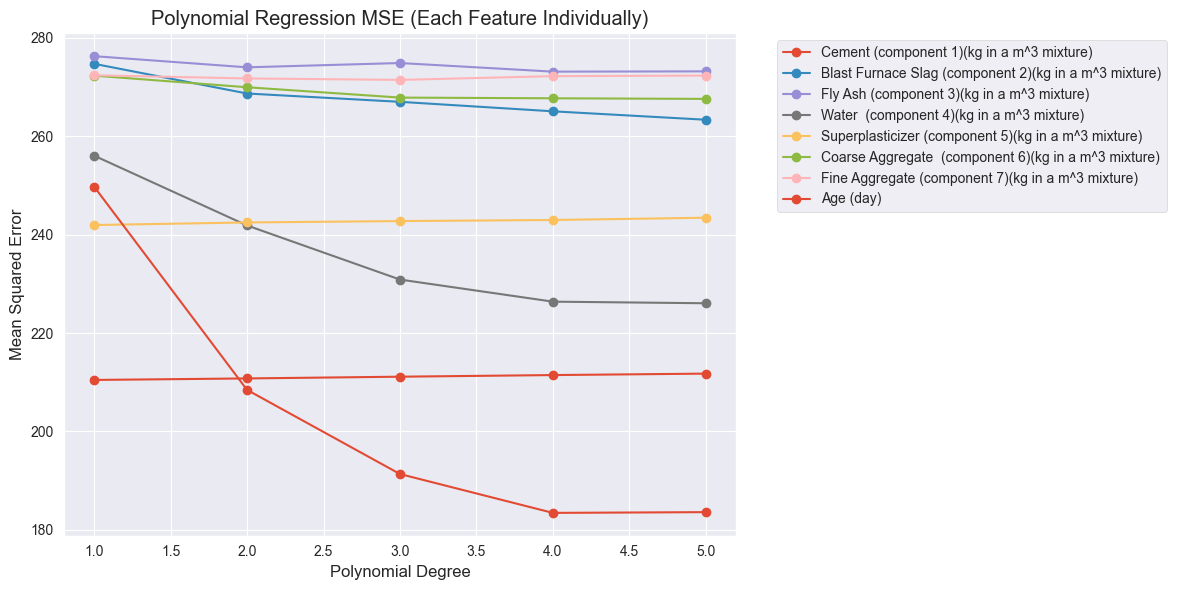

In [19]:
# Store results
results_mse = {}
results_r2 = {}

for feature in feature_columns:
    X_p = concrete_df[[feature]].values
    #Store MSE,R2
    mse_poly = []
    r2_poly = []
    for degree in range(1, 6):  # Degrees 1 to 5
                # Create polynomial features
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(X_p)
        
                # Create linear regression model
                model = LinearRegression()
        
                # Perform shuffled 10-fold CV and get negative MSE (sklearn returns negative MSE by default)
                mse_scores = cross_val_score(model, X_poly, y, scoring=mse_scorer, cv=kf)
        
                # Store average MSE
                mse_poly.append(np.mean(mse_scores))

                # Store average R2
                r2_poly.append(np.mean(r2_scores))    
        # Store MSEs for this feature
    results_mse[feature] = mse_poly
    results_r2[feature] = r2_poly
    # Plot results

plt.figure(figsize=(12, 6))
best_comb = {}
best_comb = {}

# Plot MSE
for feature, mse_list in results_mse.items():
    plt.plot(range(1, 6), mse_list, marker='o', label=feature)
    
    # Sort MSEs with their degree indices
    sorted_mse = sorted((mse, i+1) for i, mse in enumerate(mse_list))  # (MSE, degree)
    
    min_mse, best_degree = sorted_mse[0]
    best_comb[feature] = best_degree
    
    print(f"{feature}:")
    print(f"  Lowest MSE = {min_mse:.2f} at degree {best_degree}")
print(best_comb)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Polynomial Regression MSE (Each Feature Individually)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##### Polynomial Degree Selection Summary and Justification:

In order to model the relationship between the features and the concrete compressive strength, polynomial regression up to degree 5 is applied for each feature. The mean squared error (MSE) was computed using 10-fold cross-validation to assess the predictive performance at each polynomial degree.

While some features achieved their lowest MSE at higher degrees, the improvements over lower degrees were often marginal. Since high-degree polynomial models tend to overfit—capturing noise instead of the underlying patter. Both the lowest and second-lowest MSEs are considered for each feature to guide model complexity choices.

Below is a summary of the best MSEs and their associated degrees:

| Feature            | Lowest MSE | Degree | 
| ------------------ | ---------- | ------ | 
| Cement             | 232.98     | 1      | 
| Blast Furnace Slag | 303.89     | 5      | 
| Fly Ash            | 317.01     | 4      | 
| Water              | 248.95     | 4      | 
| Superplasticizer   | 272.21     | 1      |
| Coarse Aggregate   | 296.42     | 2      | 
| Fine Aggregate     | 293.30     | 1      | 
| Age                | 206.15     | 4      | 


### Re-sampling and Cross-Validation


We use <span style="color:red">resampling methods</span> to estimate the variability of a linear regression fit:
1. Draw $k$ samples from our training dataset
2. Fit a linear regression for each sample
3. Analyze how much the fits differ

Methods: 
1. Cross-validation:
    - model assessment: validate the performance of a method
    - model selection: validate model flexibility
2. Bootstrap: used to measure accuracy of the parameter estimate of accuracy of a method

To obtain a good trade-off between bias and variance during our cross-validation we opt for the k-fold CV method. The leave-one-out cross-validation (LOOCV) has a higher variance than k-fold CV ($k < n$ where $n$ is the number of total observations).
The validation set approach which is necessary for CV overestimates the test error but k-fold CV provides an intermediate level of bias. 
Training is done on:
$(k-1)*n/k$ 
observations.
We choose to have no overlap between the k-fold training-sets to minimize correlation in the outputs and therefore minimize the variance of the mean.

### Cross validation:

#### K-fold cross validation:

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [20]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [21]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

#### We compute and plot the LOOCV MSEs for polynomial regression models of degree 1 to 5 using the water feature:

#### We compute and plot the 10-fold CV MSEs for polynomial regression models of degree 1 to 5 using all features:

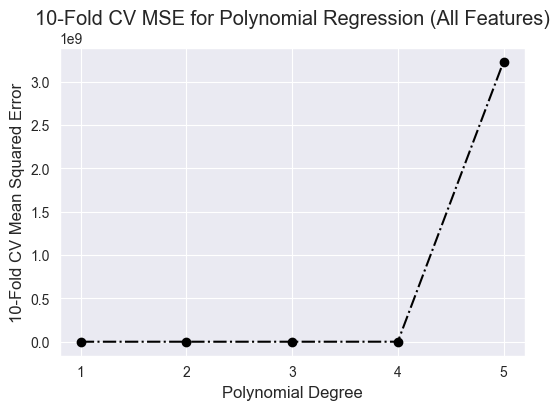

10-Fold CV MSEs for degrees 1-5: [np.float64(131.75701317724244), np.float64(95.22469991687873), np.float64(1299.7735906418177), np.float64(245701.28323940135), np.float64(3231474861.841796)]


In [23]:
degrees = [1, 2, 3, 4, 5]
kfold_mse = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    # Use 10-fold cross-validation
    scores = cross_val_score(model, X_poly, y, cv=10, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    kfold_mse.append(mse)

# Visualization
plt.figure(figsize=(6,4))
plt.plot(degrees, kfold_mse, marker='o', linestyle='-.', color='k')
plt.xlabel('Polynomial Degree')
plt.ylabel('10-Fold CV Mean Squared Error')
plt.title('10-Fold CV MSE for Polynomial Regression (All Features)')
plt.xticks(degrees)
plt.grid(True)
plt.show()

print("10-Fold CV MSEs for degrees 1-5:", kfold_mse)

#### The results show a sudden increase in the MSE for both LOOCV and 10-Fold CV at polynomial degree 5. Unfortunately there is no clear indication for a single degree of polynomial that dominates the others. The results indicate that any degree from 1 through 4 is optimal with a MSE of 0.


### Validation set approach: 

#### We compare linear, quadratic and cubic regression models and their performance. We want to predict the concrete compressive strength from the water content first.

1. We randomly split the dataframe into a training and a test set:

In [24]:
np.random.seed(0)
training = np.random.choice([False, True], size=len(X))

y_train = concrete_df['Concrete compressive strength(MPa, megapascals)'][training]
y_test = concrete_df['Concrete compressive strength(MPa, megapascals)'][~training]

2. The features with the highest positive correlation with concrete compressive strength are: cement (0.5), superplasticizer (0.37) and age (0.33). We fit a 4-dimensional model on the training set and compute the MSE with the predictions on the validation set for the age feature and then fit a 1-D linear regression model and compute the MSE in the same way for the cement and superplasticizer feature:

Polynomial Regression MSE: 193.8636

Polynomial Regression R2: 0.3204

Linear Regression MSE: 217.2547

Linear Regression R2: 0.2384

Linear Regression MSE: 254.8154

Linear Regression R2: 0.1067



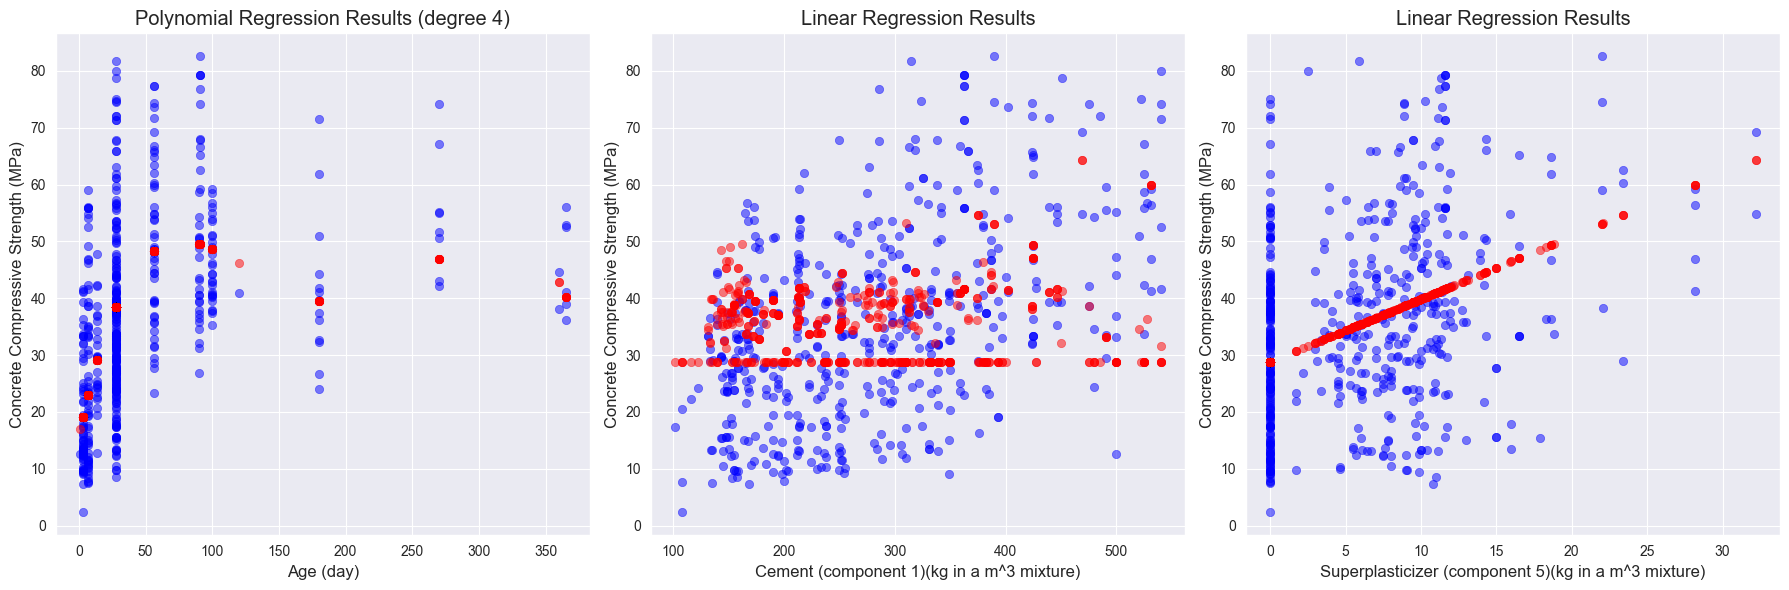


Results DataFrame:


,Feature,Model,MSE,R2
0,Age (day),Polynomial Regression (degree 4),193.863608,0.32037
1,Cement (component 1)(kg in a m^3 mixture),Linear Regression,254.815389,0.10669
2,Superplasticizer (component 5)(kg in a m^3 mix...,Linear Regression,254.815389,0.10669


In [25]:
# Split the data into training and test sets for the age feature (4-D polynomial)
X_train = sm.add_constant(np.column_stack((concrete_df['Age (day)'][training], concrete_df['Age (day)'][training] ** 2, concrete_df['Age (day)'][training] ** 3, concrete_df['Age (day)'][training] ** 4)))
X_test = sm.add_constant(np.column_stack((concrete_df['Age (day)'][~training], concrete_df['Age (day)'][~training] ** 2, concrete_df['Age (day)'][~training] ** 3, concrete_df['Age (day)'][~training] ** 4)))

# Fit the model
model = sm.OLS(y_train, X_train)
poly_results = model.fit()

y_predictions_poly = poly_results.predict(X_test)
# Calculate MSE and R2      
mse_poly = mean_squared_error(y_test, y_predictions_poly)
r2_poly = r2_score(y_test, y_predictions_poly)
print(f"Polynomial Regression MSE: {mse_poly:.4f}\n")
print(f"Polynomial Regression R2: {r2_poly:.4f}\n")

# Split the data into training and test sets for the cement feature (linear regression)
X_train = sm.add_constant(concrete_df['Cement (component 1)(kg in a m^3 mixture)'][training])
X_test = sm.add_constant(concrete_df['Cement (component 1)(kg in a m^3 mixture)'][~training])

# Fit the model
model = sm.OLS(y_train, X_train)
lin_results = model.fit()
y_predictions_lin = lin_results.predict(X_test)

# Calculate MSE and R2
mse_lin = mean_squared_error(y_test, y_predictions_lin)
r2_lin = r2_score(y_test, y_predictions_lin)
print(f"Linear Regression MSE: {mse_lin:.4f}\n")
print(f"Linear Regression R2: {r2_lin:.4f}\n")

# Split the data into training and test sets for the superplasticizer feature (linear regression)
X_train = sm.add_constant(concrete_df['Superplasticizer (component 5)(kg in a m^3 mixture)'][training])
X_test = sm.add_constant(concrete_df['Superplasticizer (component 5)(kg in a m^3 mixture)'][~training])

# Fit the model
model = sm.OLS(y_train, X_train)    
lin_results = model.fit()
y_predictions_lin = lin_results.predict(X_test)

# Calculate MSE and R2
mse_lin = mean_squared_error(y_test, y_predictions_lin)
r2_lin = r2_score(y_test, y_predictions_lin)
print(f"Linear Regression MSE: {mse_lin:.4f}\n")
print(f"Linear Regression R2: {r2_lin:.4f}\n")

# Plot the results for age, cement, and superplasticizer
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Plot for Age
ax1.scatter(concrete_df['Age (day)'][~training], y_test, color='blue', label='Actual', alpha=0.5)
ax1.scatter(concrete_df['Age (day)'][~training], y_predictions_poly, color='red', label='Predicted', alpha=0.5)
ax1.set_xlabel('Age (day)')
ax1.set_ylabel('Concrete Compressive Strength (MPa)')
ax1.set_title('Polynomial Regression Results (degree 4)')
# Plot for Cement
ax2.scatter(concrete_df['Cement (component 1)(kg in a m^3 mixture)'][~training], y_test, color='blue', label='Actual', alpha=0.5)
ax2.scatter(concrete_df['Cement (component 1)(kg in a m^3 mixture)'][~training], y_predictions_lin, color='red', label='Predicted', alpha=0.5)
ax2.set_xlabel('Cement (component 1)(kg in a m^3 mixture)')
ax2.set_ylabel('Concrete Compressive Strength (MPa)')
ax2.set_title('Linear Regression Results')
# Plot for Superplasticizer
ax3.scatter(concrete_df['Superplasticizer (component 5)(kg in a m^3 mixture)'][~training], y_test, color='blue', label='Actual', alpha=0.5)
ax3.scatter(concrete_df['Superplasticizer (component 5)(kg in a m^3 mixture)'][~training], y_predictions_lin, color='red', label='Predicted', alpha=0.5)
ax3.set_xlabel('Superplasticizer (component 5)(kg in a m^3 mixture)')
ax3.set_ylabel('Concrete Compressive Strength (MPa)')
ax3.set_title('Linear Regression Results')
plt.tight_layout()
plt.show()

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Feature': ['Age (day)', 'Cement (component 1)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)'],
    'Model': ['Polynomial Regression (degree 4)', 'Linear Regression', 'Linear Regression'],
    'MSE': [mse_poly, mse_lin, mse_lin],
    'R2': [r2_poly, r2_lin, r2_lin]
})
print("\nResults DataFrame:")
display(results_df)

3. The feature with the highest negative correlation with the concrete compressive strength is water content. We fit a 4-dimensional regression model on the training set and compute the MSE with the predictions on the validation set (as a test set):

Polynomial Regression MSE: 236.6172

Polynomial Regression R2: 0.1705



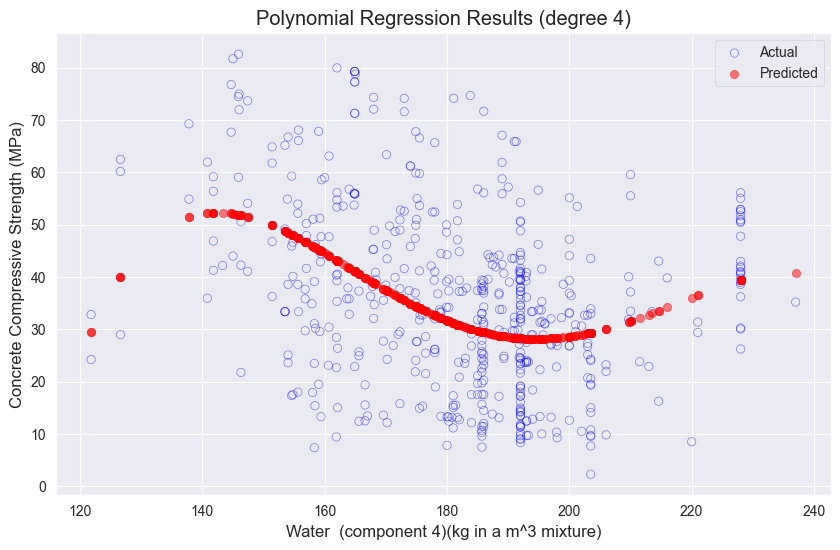

In [26]:
X_train = sm.add_constant(np.column_stack((concrete_df['Water  (component 4)(kg in a m^3 mixture)'][training], concrete_df['Water  (component 4)(kg in a m^3 mixture)'][training] ** 2, concrete_df['Water  (component 4)(kg in a m^3 mixture)'][training] ** 3, concrete_df['Water  (component 4)(kg in a m^3 mixture)'][training] ** 4)))
X_test = sm.add_constant(np.column_stack((concrete_df['Water  (component 4)(kg in a m^3 mixture)'][~training], concrete_df['Water  (component 4)(kg in a m^3 mixture)'][~training] ** 2, concrete_df['Water  (component 4)(kg in a m^3 mixture)'][~training] ** 3, concrete_df['Water  (component 4)(kg in a m^3 mixture)'][~training] ** 4)))

# Fit the model
model = sm.OLS(y_train, X_train)
poly_results = model.fit()

y_predictions_poly = poly_results.predict(X_test)
# Calculate MSE and R2      
mse_poly = mean_squared_error(y_test, y_predictions_poly)
r2_poly = r2_score(y_test, y_predictions_poly)
print(f"Polynomial Regression MSE: {mse_poly:.4f}\n")
print(f"Polynomial Regression R2: {r2_poly:.4f}\n")
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(concrete_df['Water  (component 4)(kg in a m^3 mixture)'][~training], y_test, facecolors='none', edgecolors='b', label='Actual', alpha=0.5)
plt.scatter(concrete_df['Water  (component 4)(kg in a m^3 mixture)'][~training], y_predictions_poly, color='r', label='Predicted', alpha=0.5)
plt.xlabel('Water  (component 4)(kg in a m^3 mixture)')
plt.ylabel('Concrete Compressive Strength (MPa)')
plt.title('Polynomial Regression Results (degree 4)')
plt.legend()
plt.show()  

1. Feature Selection with Recursive Feature Elimination (RFE)

In [27]:
from sklearn.feature_selection import RFECV

# Use linear regression as the estimator
estimator = LinearRegression()
rfecv = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features:", [feature_columns[i] for i, x in enumerate(rfecv.support_) if x])

# Plot number of features vs. CV scores
plt.figure(figsize=(6,4))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), -rfecv.grid_scores_, marker='o')
plt.xlabel("Number of features selected")
plt.ylabel("CV Mean Squared Error")
plt.title("Recursive Feature Elimination")
plt.show()

Optimal number of features: 6
Selected features: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Age (day)']


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

<Figure size 600x400 with 0 Axes>

2. Regularization: Ridge and Lasso Regression with Cross-Validation

Best Ridge alpha: 1000.0000, MSE: 131.62
Best Lasso alpha: 0.0010, MSE: 107.20


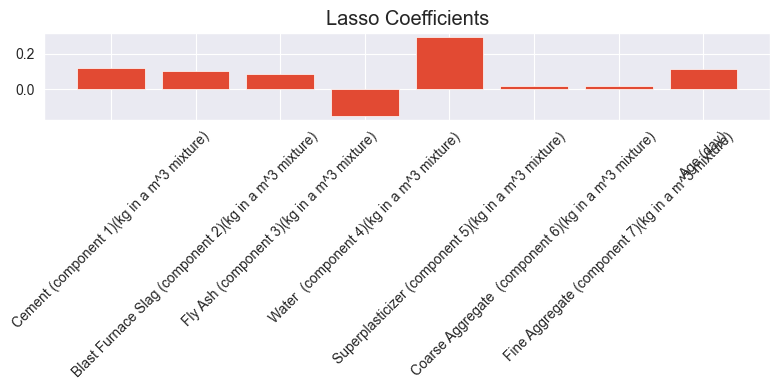

In [28]:
from sklearn.linear_model import RidgeCV, LassoCV

# Ridge Regression with CV
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)
print(f"Best Ridge alpha: {ridge_cv.alpha_:.4f}, MSE: {-ridge_cv.best_score_:.2f}")

# Lasso Regression with CV
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 100), cv=10, max_iter=10000)
lasso_cv.fit(X, y)
mse_lasso = np.mean((lasso_cv.predict(X) - y) ** 2)
print(f"Best Lasso alpha: {lasso_cv.alpha_:.4f}, MSE: {mse_lasso:.2f}")

# Plot Lasso coefficients
plt.figure(figsize=(8,4))
plt.bar(feature_columns, lasso_cv.coef_)
plt.title("Lasso Coefficients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3. Dimension Reduction: Principal Component Regression (PCR)

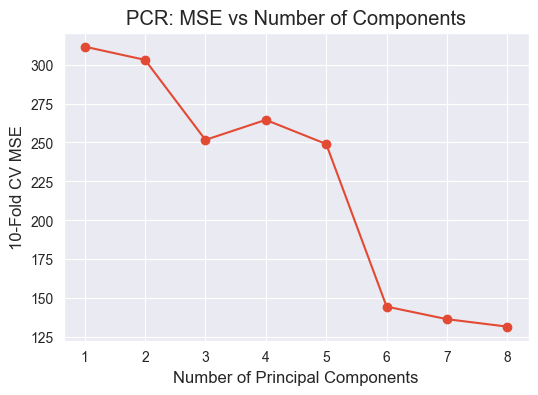

Best PCR components: 8, MSE: 131.76


In [29]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Try PCR with different numbers of components
mse_pcr = []
components = range(1, X.shape[1]+1)
for n in components:
    pcr = Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('lr', LinearRegression())
    ])
    scores = cross_val_score(pcr, X, y, cv=10, scoring='neg_mean_squared_error')
    mse_pcr.append(-scores.mean())

plt.figure(figsize=(6,4))
plt.plot(components, mse_pcr, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("10-Fold CV MSE")
plt.title("PCR: MSE vs Number of Components")
plt.show()

best_n = np.argmin(mse_pcr) + 1
print(f"Best PCR components: {best_n}, MSE: {mse_pcr[best_n-1]:.2f}")

4. Model Comparison Summary

In [30]:
print(f"Linear Regression (all features) 10-fold CV MSE: {kfold_mse[0]:.2f}")
print(f"Ridge Regression best MSE: {-ridge_cv.best_score_:.2f}")
print(f"Lasso Regression best MSE: {mse_lasso:.2f}")
print(f"PCR best MSE: {mse_pcr[best_n-1]:.2f}")

# You can also compare with your best polynomial regression MSEs from previous cells.

Linear Regression (all features) 10-fold CV MSE: 131.76
Ridge Regression best MSE: 131.62
Lasso Regression best MSE: 107.20
PCR best MSE: 131.76


#### Hyperparameter Tuning + Ensemble methods (like Random Forests):

Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest best 10-fold CV MSE: 54.53
Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting best 10-fold CV MSE: 44.59

--- Model Comparison (10-fold CV MSE) ---
Linear Regression: 131.76
Ridge Regression: 131.62
Lasso Regression: 107.20
PCR: 131.76
Random Forest: 54.53
Gradient Boosting: 44.59


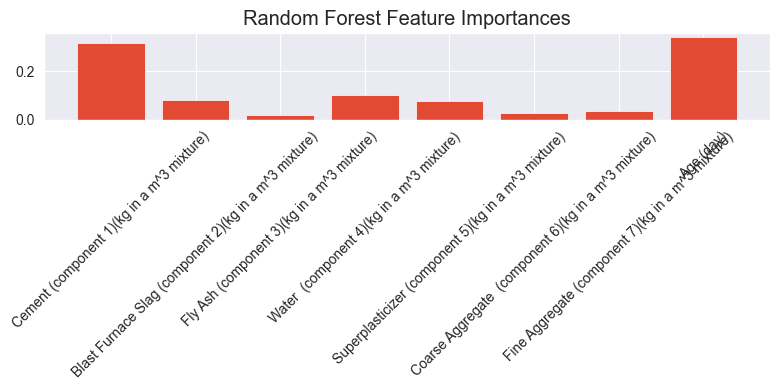

In [31]:
# --- Hyperparameter Tuning and Ensemble Methods ---

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# 1. Random Forest Regressor with Grid Search
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=0)
rf_grid = GridSearchCV(rf, rf_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X, y)
print(f"Best Random Forest params: {rf_grid.best_params_}")
print(f"Random Forest best 10-fold CV MSE: {-rf_grid.best_score_:.2f}")

# 2. Gradient Boosting Regressor with Grid Search
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb = GradientBoostingRegressor(random_state=0)
gb_grid = GridSearchCV(gb, gb_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X, y)
print(f"Best Gradient Boosting params: {gb_grid.best_params_}")
print(f"Gradient Boosting best 10-fold CV MSE: {-gb_grid.best_score_:.2f}")

# 3. Compare all models
print("\n--- Model Comparison (10-fold CV MSE) ---")
print(f"Linear Regression: {kfold_mse[0]:.2f}")
print(f"Ridge Regression: {-ridge_cv.best_score_:.2f}")
print(f"Lasso Regression: {mse_lasso:.2f}")
print(f"PCR: {mse_pcr[best_n-1]:.2f}")
print(f"Random Forest: {-rf_grid.best_score_:.2f}")
print(f"Gradient Boosting: {-gb_grid.best_score_:.2f}")

# 4. Feature importances from the best Random Forest
importances = rf_grid.best_estimator_.feature_importances_
plt.figure(figsize=(8,4))
plt.bar(feature_columns, importances)
plt.title("Random Forest Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Hyperparameter Tuning and Ensemble Methods (in our case Random Forest):

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1148 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  F

Best Random Forest params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Random Forest best 10-fold CV MSE: 54.66
Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5760 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2314 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  

Best Gradient Boosting params: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Gradient Boosting best 10-fold CV MSE: 37.52

--- Model Comparison (10-fold CV MSE) ---
Linear Regression: 131.76
Ridge Regression: 131.62
Lasso Regression: 107.20
PCR: 131.76
Random Forest: 54.66
Gradient Boosting: 37.52


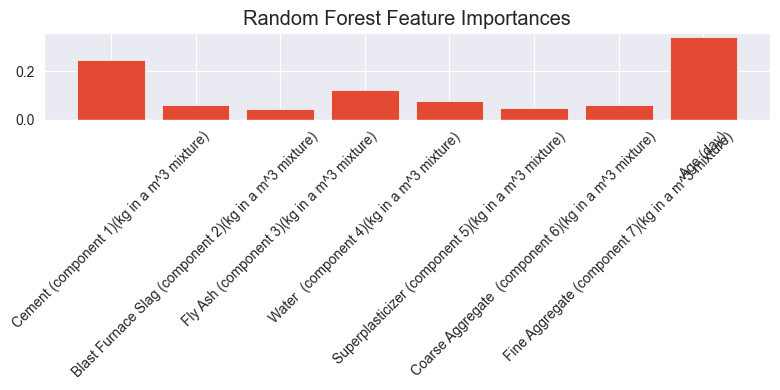

In [32]:
# --- Expanded Hyperparameter Tuning for Ensemble Methods ---

# Expanded parameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=0)
rf_grid = GridSearchCV(
    rf, rf_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2
)
rf_grid.fit(X, y)
print(f"Best Random Forest params: {rf_grid.best_params_}")
print(f"Random Forest best 10-fold CV MSE: {-rf_grid.best_score_:.2f}")

# Expanded parameter grid for Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
gb = GradientBoostingRegressor(random_state=0)
gb_grid = GridSearchCV(
    gb, gb_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2
)
gb_grid.fit(X, y)
print(f"Best Gradient Boosting params: {gb_grid.best_params_}")
print(f"Gradient Boosting best 10-fold CV MSE: {-gb_grid.best_score_:.2f}")

# Compare all models again
print("\n--- Model Comparison (10-fold CV MSE) ---")
print(f"Linear Regression: {kfold_mse[0]:.2f}")
print(f"Ridge Regression: {-ridge_cv.best_score_:.2f}")
print(f"Lasso Regression: {mse_lasso:.2f}")
print(f"PCR: {mse_pcr[best_n-1]:.2f}")
print(f"Random Forest: {-rf_grid.best_score_:.2f}")
print(f"Gradient Boosting: {-gb_grid.best_score_:.2f}")

# Feature importances from the best Random Forest
importances = rf_grid.best_estimator_.feature_importances_
plt.figure(figsize=(8,4))
plt.bar(feature_columns, importances)
plt.title("Random Forest Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Let's compare model performance in a table:

In [ ]:
# Collect model performances
model_names = [
    "Linear Regression",
    "Ridge Regression",
    "Lasso Regression",
    "PCR",
    "Random Forest",
    "Gradient Boosting"
]
mse_values = [
    kfold_mse[0],                        # Linear Regression (degree 1, all features)
    -ridge_cv.best_score_,               # Ridge Regression
    mse_lasso,                           # Lasso Regression
    mse_pcr[best_n-1],                   # PCR
    -rf_grid.best_score_,                # Random Forest
    -gb_grid.best_score_                 # Gradient Boosting
]

# Create summary DataFrame
summary_df = pd.DataFrame({
    "Model": model_names,
    "10-Fold CV MSE": mse_values
})

# Sort by MSE (lower is better)
summary_df = summary_df.sort_values("10-Fold CV MSE").reset_index(drop=True)

print("Model Performance Summary (sorted by MSE):")
display(summary_df)

Model Performance Summary (sorted by MSE):


,Model,10-Fold CV MSE
0,Gradient Boosting,37.519281
1,Random Forest,54.657861
2,Lasso Regression,107.197236
3,Ridge Regression,131.617916
4,PCR,131.757013
5,Linear Regression,131.757013
